# Which country will first-time airbnb users choose?

***
### Brief
New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

Airbnb wants to predict in which destination country a new user from the USA will make his or her first booking:
1. United States of America
2. France
3. Canada
4. Great Britain
5. Estonia
6. Italy
7. Portugal
8. Netherlands
9. Germany
10. Australia  
11. No Destination Found (NDF) 
12. Other

Please note that since I'm doing this project after the Kaggle competition was closed, I'm focussing solely focusing on the training data provided as their test data did not have the destination country label and so makes it impossible for me to test the "accuracy" of my predictions. The analysis and exploration of the test data is kept within this document for comparison purposes with the work completed by others.


### The Data
The data has been provided by airbnb and downloaded from Kaggle. And the [data](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data) contains a rich set of demographics, web session records, and some summary statistics data on about 275,562 (train + test) users from the USA. For context, I've also explored the [international](http://travel.trade.gov/view/m-2015-O-001/index.html) and [domestic](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/) travel data for US Citizens for 2015.


### Evaluation Metric

Most classification algorithms use accuracy (the percentage of observations correctly classified) as their evaluation metric. But with an imbalanced dataset the results are skwed towards the majority class. ____ in order to optimise for ____(accuracy/recall/?). Evaluation based on chi square, but why?


### Limitations
1. before early 2013 users could make bookings without creating an account
2. where date_first_booking is populated with "NAN" (Not A Number) the destination country is also given as NDF
3. the test data set does not have date_first_booking or country destination populated
4. training data covers January 2010 to June 2014 while the testing data covers July 2014 onward. 
5. session data only ties back to users starting from 2014 onward.
6. missing data or data munging that need to be done?
7. outliers?
8. unbalanced dataset, skewed to NDF (±60%) and the US (±30%) 
9. What are the similarities/differences in the destination countries?
10. Demographic differences that could point to preferences?
11. Investigate the impact that user interaction with the website has on destination selection.

***
# Data Exploration

Going in, *my hunch* is that the majority of first time US airbnb users will choose destinations within the USA and then tend to favour Canada and European countries to Australia. 

This is based on data for [international travel](http://travel.trade.gov/view/m-2015-O-001/index.html) by U.S. citizens for the first 10 months of 2015, where all of Europe saw 11,067,879 U.S. citizens (18% of 61,322,698), just above the Canadian figure (11,008,848 citizens; 18%), but still half of number going to Mexico (22,641,533; 36.9% of total). Oceania (used as proxy for Australia in this example) saw 0.8% (511,563) of U.S. citizens visit their shores. In terms of [domestic travel](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/), U.S. citizens took 458.3 million business trips and 1,692.8 million leisure trips in 2015.

What I will be exploring:
* data integrity:
  * the level of missing data 
  * impact of outliers 
  * the amount of data cleaning that will be required before anlaysis can be done


* testing feature characteristics that could point to country preferences:
  * demographic (age, language, gender)
  * how the user come to the website initially (affiliate_channel, affiliate_provider, first_affiliate_tracked)
  * how the user interacts with the website (first_browser,first_device_type)
  * impact of signup process (signup_app, signup_flow, signup_method) on whether the person ends up making a booking or not.
  * after creating an account (date_account_created), what is the delay in searching for places to stay (timestamp_first_active)? And post account creation, how long does it take to finalize the booking (date_first_booking)? And what kind of prediction accuracy do these indicators have?
  

* external influencers about the destination countries themselves that could be attractive to certain users:
 * the distance to the destination (distance_km)
 * how big the country is could potentially point to there being more to explore (destination_km2)
 * foreign, but familiar. Whether english is widely-spoken in the destination country has an impact on it's desirability (destination_language, language_levenshtein_distance)
 

In [85]:
# load and transform
from time import time
import zipfile
from datetime import datetime
import numpy as np
import pandas as pd

# stats
import scipy.stats as stats

# ml
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics, feature_selection
from rank_metrics import ndcg_at_k
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# graphics
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')

#print(plt.style.available)

In [55]:
# unzip and read data
%run load.py

df_countries => rows: 10; columns: 7
df_country_demographics => rows: 420; columns: 5
df_user_sessions => rows: 10567737; columns: 6
df_train => rows: 213451; columns: 16
df_test => rows: 62096; columns: 15
df_users => rows: 275547; columns: 16


***
## Who are these first-time users?

I've combined the train and test data to get a better handle on the overall completeness of the sample since an algorthim that performs well on the training data will only do well if the test data is as rich as the training data.

In [56]:
print("Number of users in the training set: %0.0f\n\
Number of users in the test set: %0.0f" % (np.shape(df_train)[0], np.shape(df_test)[0]))
print("Full Set Rows: %0.0f\n\
Full Set Columns: %0.0f" % np.shape(df_users))

Number of users in the training set: 213451
Number of users in the test set: 62096
Full Set Rows: 275547
Full Set Columns: 16


The training data represents just over three-quarters of the total sample, but it seems like both data sets have the same poorly populated fields. Except that the test set has no values for 'date_first_booking ' and 'country_destination'.

In [57]:
users_nan = df_users.replace('-unknown-', np.nan)
users_nan_counts = users_nan.isnull().sum().sort_values(ascending=False)
users_nan_summary = (users_nan_counts / users_nan.shape[0]) * 100
users_nan_notzero = users_nan_summary[users_nan_summary > 0]

print('% of rows with missing values')
print('--------------------------------------------------')
print(users_nan_notzero)

% of rows with missing values
--------------------------------------------------
date_first_booking         67.733998
gender                     46.990169
age                        42.412365
country_destination        22.535538
first_browser              16.111226
first_affiliate_tracked     2.208335
language                    0.000363
dtype: float64


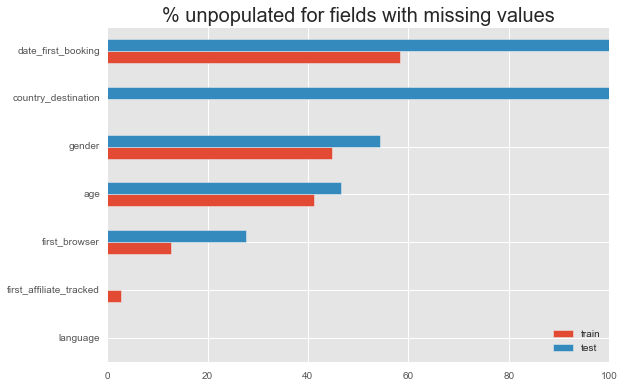

In [58]:
train_nan = df_train.replace('-unknown-', np.nan)
train_nan_counts = train_nan.isnull().sum().sort_values(ascending=False)
train_nan_summary = (train_nan_counts / train_nan.shape[0]) * 100
train_nan_notzero = train_nan_summary[train_nan_summary > 0]

test_nan = df_test.replace('-unknown-', np.nan)
test_nan['country_destination'] = np.nan #the test set doesn't have this field
test_nan_counts = test_nan.isnull().sum().sort_values(ascending=False)
test_nan_summary = (test_nan_counts / test_nan.shape[0]) * 100
test_nan_notzero = test_nan_summary[test_nan_summary > 0]

nan_comparison = pd.concat([train_nan_notzero,test_nan_notzero], axis=1) 
nan_comparison.columns = ['train','test']
nan_comparison.sort_values('test', ascending=True).plot(kind='barh')
plt.title('% unpopulated for fields with missing values', fontsize=20)
plt.legend(loc='lower right');

From the chart above I glean that I can't use *date_first_booking* for prediction. It's not held in the test set so even if I get a good fit based on the training data there is no way of fitting it to the test data. That leaves me with *date_account_created* and *timestamp_first_active*. The session data might hold the key to tying some booking info back to the test dataset.

Also, taking a closer look at the content of the different fields, it becomes clear that age is not only poorly populated, but there also seems to be a lack of field validation being applied.

In [59]:
# check what the fields are populated with for the train data set
for column in df_train:
    print([column], df_train[column].unique())

(['id'], array(['gxn3p5htnn', '820tgsjxq7', '4ft3gnwmtx', ..., '6o3arsjbb4',
       'jh95kwisub', 'nw9fwlyb5f'], dtype=object))
(['date_account_created'], array(['2010-06-28', '2011-05-25', '2010-09-28', ..., '2014-06-27',
       '2014-06-29', '2014-06-30'], dtype=object))
(['timestamp_first_active'], array([20090319043255, 20090523174809, 20090609231247, ..., 20140630235754,
       20140630235822, 20140630235824], dtype=int64))
(['date_first_booking'], array([nan, '2010-08-02', '2012-09-08', ..., '2015-06-25', '2015-06-29',
       '2015-06-28'], dtype=object))
(['gender'], array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object))
(['age'], array([             nan,   3.80000000e+01,   5.60000000e+01,
         4.20000000e+01,   4.10000000e+01,   4.60000000e+01,
         4.70000000e+01,   5.00000000e+01,   3.60000000e+01,
         3.70000000e+01,   3.30000000e+01,   3.10000000e+01,
         2.90000000e+01,   3.00000000e+01,   4.00000000e+01,
         2.60000000e+01,   3.20000000e+01

In [60]:
print(df_train.age.describe())
print("")
print(">100: %3.0f (%3.2f%%)" % (sum(df_train.age>100), float(sum(df_train.age>100))/float(sum(df_train.age>0))*100))
print("<18: %3.0f (%3.2f%%)" % (sum(df_train.age<18), float(sum(df_train.age<18))/float(sum(df_train.age>0))*100))

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

>100: 2345 (1.87%)
<18: 158


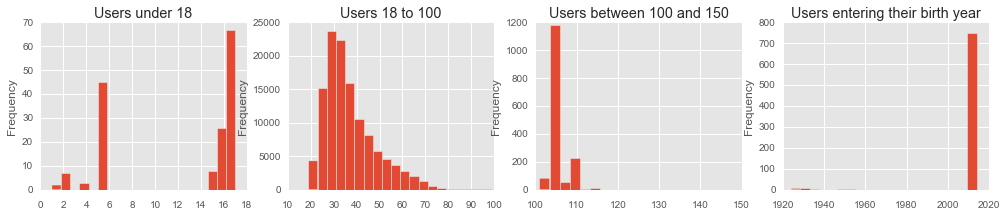

In [61]:
# plot age distributions
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17,3))
df_train[(df_train.age<18)].age.plot(kind='hist', title='Users under 18', bins=20, ax=axes[0])
df_train[(df_train.age>18) & (df_train.age<100)].age.plot(kind='hist', title='Users 18 to 100', bins=20, ax=axes[1])
df_train[(df_train.age>100) & (df_train.age<200)].age.plot(kind='hist', title='Users between 100 and 150', bins=20, ax=axes[2]);
df_train[(df_train.age>200)].age.plot(kind='hist', title='Users entering their birth year', bins=20, ax=axes[3]);

So around 42% of the age data is incomplete, bit it seems the remaing +/- 58% needs same cleaning.

I've got some 1-6 year olds signing up and some teens. And on the other isde of the spectrum I have a strong contigent of people over a houndred. 1-6 year olds are unlikely to be creating profiles of any sort online. And centenatians numbar about 55,000 and make up about 0.02% of the US population ([source](http://www.census.gov/prod/2014pubs/acsbr12-18.pdf?eml=gd&utm_medium=email&utm_source=govdelivery)) so centenarians are either over represented in Airbnb's sample (by 100 times) or the data is incorrectly captured. My money is on incorrrectly captured. There is another section of the age data that seems to require correction with birth years having been entred instead of their age.

In [62]:
# fix incorrectly populated ages.
av = df_train.age.values
# fix those with year of birth as age
df_train['age'] = np.where(np.logical_and(av>1900, av<2015), 2015-av, av)
# set all ages deemed unlikely as null
df_train['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av)

After fixing incorrect ages, the right-skewed nature of the ages remained after this correction, but the mean (36 years) and median (33) are much closer now (a difference of 3 years instead of the initial 14).

In [63]:
df_train.age.describe()

count    123088.000000
mean         36.568837
std          11.708014
min          15.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

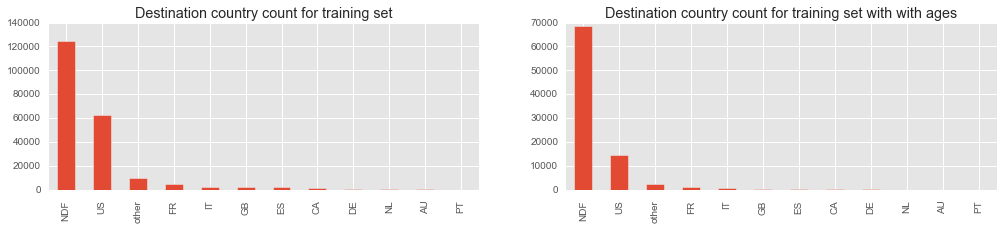

In [64]:
# Country break-down on the training set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,3))
fig1 = df_train.country_destination.value_counts().plot(kind='bar', 
    title='Destination country count for training set', ax=axes[0])
fig2 = df_train[df_train.age.isnull()].country_destination.value_counts().plot(kind='bar', 
    title='Destination country count for training set with with ages', ax=axes[1])

It would also seem like removing the records without age data populated would leave the rank order in tack, but it looks like the distribution would be even more rightr skewed, with NDF and US counts being most dramatically affected.

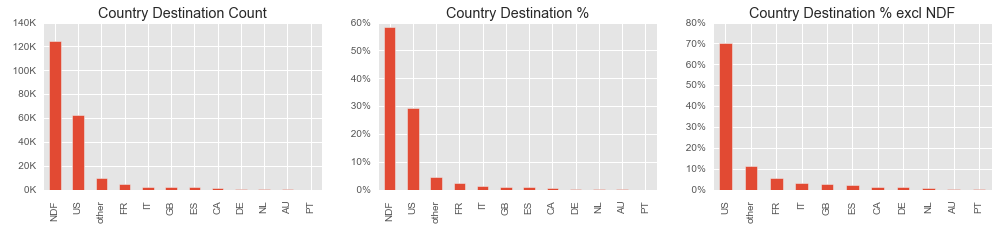

In [65]:
# Country break-down on the training set
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,3))
# destination count
country_counts = df_train.country_destination.value_counts()
fig1 = country_counts.plot(kind='bar', title='Country Destination Count', ax=axes[0])
fig1.set_yticklabels(['{:5,.0f}K'.format(x/1000) for x in fig1.get_yticks()]);
# destination %
fig2 = country_counts.div(country_counts.sum()).plot(kind='bar', title='Country Destination %', ax=axes[1])
fig2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in fig2.get_yticks()])
# % excl NDF
booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
fig3 = booked_count.div(booked_count.sum()).plot(kind='bar', title='Country Destination % excl NDF', ax=axes[2])
fig3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in fig3.get_yticks()]);

The fact that NDF makes up about ±60% of the data and the US another ±30% indicates that we're dealing with an __imbalanced__ dataset. And with about ±60% of users not making a booking and if thsoe that do, ±70% select the US. The fact that the majority of travel for US citizens occurs within the US is very much in-line with the US travel statistics. However, I would have expected Cananda (CA) to be 18% mark and if we assume that Mexico has been rolled into the 'other' group, then is about a third of what would be expected for this group (>38%).

Options in order to deal with imbalanced datasets:
1. Undersampling
2. Oversampling
3. Synthetic Data Generation (SMOTE)
4. Cost Sensitive Learning (CSL)

Since there are about 125,461 observations within the provided training set alone, I might try undersampling the over-represented NDF class first and see what type of results I get.

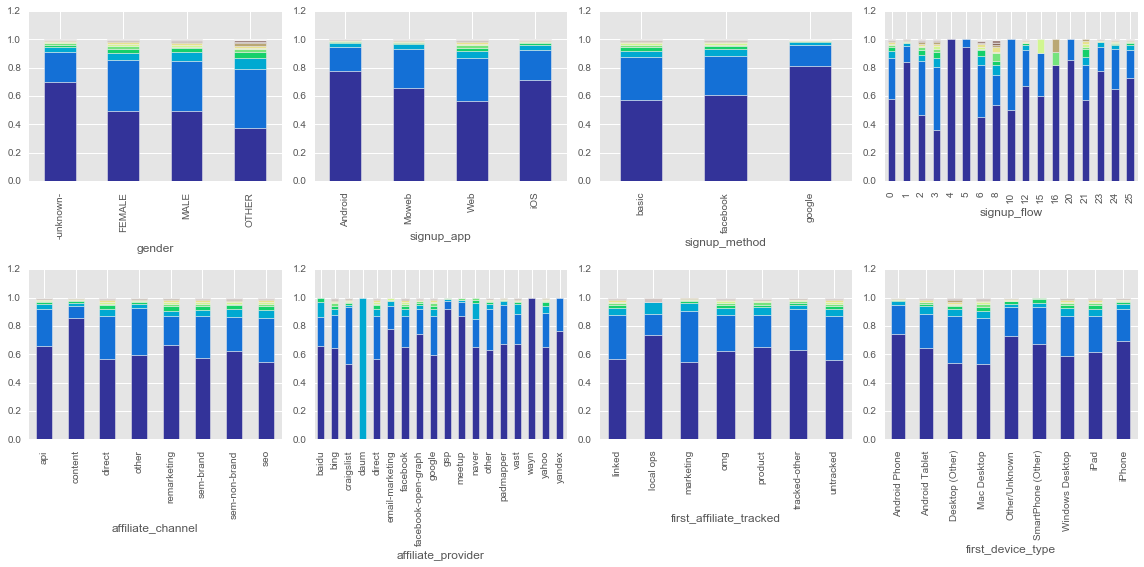

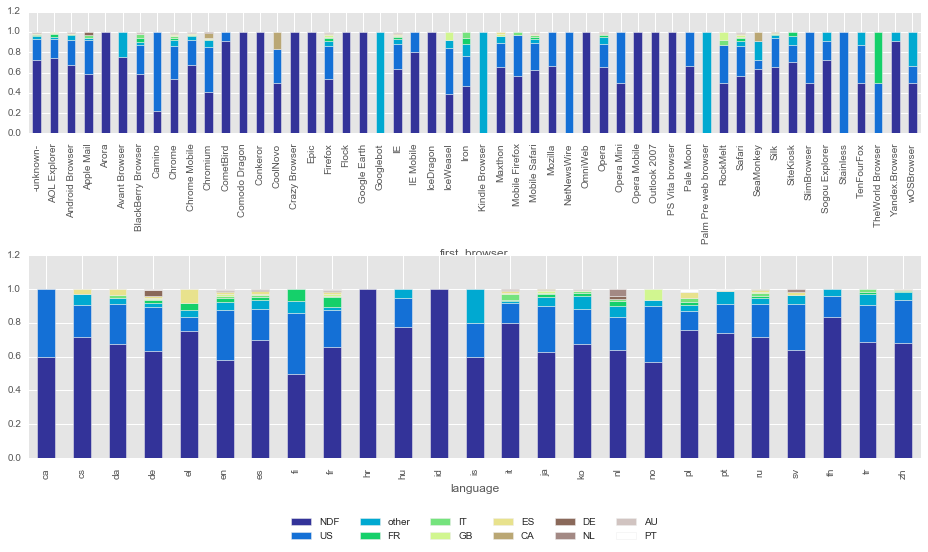

In [66]:
# populate the metrics by country
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender', 'signup_app', 'signup_method', 'signup_flow', 
            'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'first_device_type', 
            'first_browser', 
            'language']

fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
def pltCatVar(var,axis,ax_num):
    ctab = pd.crosstab([df_train[var]], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num], legend=False, colormap='terrain')
    
for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i)
plt.tight_layout()

fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)
for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i)
    
box = ax5[0].get_position()
ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6);

The following seesms to pop-up from the charts above:
* Those that self identify as either male or female tends to have the same pattern in leading to either NDF or US as outcome.
* Users signing up using a desktop computer tend choose a more diverse selection of destinations.
* Users with the 'google' signup_method book less frequently than 'basic' or 'facebook'
* Users with signup_flow 3 book more frequently than any other category while about 9 have a greater than average (60%) outcome that is 'NDF'
* Users with 'content' as affiliate_channel book less frequently than other channels
* Users with 'craigslist', 'direct', and 'google' as affiliate_provider book more frequently than other providers
* Users with first_affiliate_tracked 'local ops' book less frequently than the rest
* Users with first_device_type 'Desktop (Other)' 'Mac_Desktop' booked the most frequently, while those with 'Android Phone' and 'Other/Unknown' booked the least
* I'm not quite sure what to make from the 'first_browser' break-down.
* The chart on language is somewhat surprising given that all the users are said to be US citizens. From my interpretation of the shortened language names, I think it's telling me that if you have English, Finish or Norwegian as a language preference then you are more likely to book. 

***
## What does user engagement on the airbnb website look like?

The definition of 'secs_elapsed' is a bit unclear to me. But I think it could abpple to either the recorded time between two actions or the total time the browsing sessions is open.

In [68]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(df_user_sessions))
df_user_sessions.tail()

Rows: 10567737; Columns: 6


,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221.0


In [69]:
top_tail = df_user_sessions[df_user_sessions.user_id.isin(['d1mm9tcy42','9uqfg8txu3'])].sort_values('action')
top_tail.groupby(['user_id','action','action_type','action_detail']).count()

device_type  \
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                              2   
           callback                    partner_callback oauth_response                         1   
           create                      submit           create_phone_numbers                   2   
           dashboard                   view             dashboard                              1   
           edit                        view             edit_profile                           4   
           header_userpic              data             header_userpic                         1   
           languages_multiselect       -unknown-        -unknown-                              1   
           show                        view             user_profile                           1   
           show_personalize            data             user_profile_content_update            1   
           update                      submit           update_user_profile                    1   
           webcam_upload               -unknown-        -unknown-                              1   
d1mm9tcy42 active                      -unknown-        -unknown-                              1   
           ajax_refresh_subtotal       click            change_trip_characteristics            8   
           ask_question                submit           contact_host                           1   
           decision_tree               -unknown-        -unknown-                              1   
           faq_experiment_ids          -unknown-        -unknown-                              1   
           header_userpic              data             header_userpic                         1   
           hosting_social_proof        -unknown-        -unknown-                              2   
           index                       view             view_search_results                   11   
           multi                       -unknown-        -unknown-                              1   
           other_hosting_reviews_first -unknown-        -unknown-                              1   
           personalize                 data             wishlist_content_update               25   
           recent_reservations         -unknown-        -unknown-                              1   
           search_results              click            view_search_results                   12   
           show                        view             p3                                    14   
           similar_listings            data             similar_listings                       9   

                                                                                     secs_elapsed  
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                               2  
           callback                    partner_callback oauth_response                          0  
           create                      submit           create_phone_numbers                    2  
           dashboard                   view             dashboard                               1  
           edit                        view             edit_profile                            4  
           header_userpic              data             header_userpic                          1  
           languages_multiselect       -unknown-        -unknown-                               1  
           show                        view             user_profile                            1  
           show_personalize            data             user_profile_content_update             1  
           update                      submit           update_user_profile                     1  
           webcam_upload               -unknown-        -unknown-                   

In [70]:
sessions_nan = df_user_sessions.replace('-unknown-', np.nan)
sessions_nan_counts = sessions_nan.isnull().sum().sort_values(ascending=False)
sessions_nan_summary = (sessions_nan_counts / sessions_nan.shape[0]) * 100

print('Number  of rows with missing values')
print('-------------------------------------')
print(sessions_nan_counts)

print('% of rows with missing values')
print('-------------------------------------')
print(sessions_nan_summary)

Number  of rows with missing values
-------------------------------------
action_type      2157374
action_detail    2157345
device_type       211279
secs_elapsed      136031
action             79626
user_id            34496
dtype: int64
% of rows with missing values
-------------------------------------
action_type      20.414721
action_detail    20.414446
device_type       1.999283
secs_elapsed      1.287229
action            0.753482
user_id           0.326428
dtype: float64


The session data seems to hold a rich variety of metrics, but the aren't really well populated for action type and action detail. And it would seems like unknowns in action type would also mean unknwons in actiona detail. But do I care about these fields?

In [71]:
# What values do action types tend to hold?
sessions_action_types = (df_user_sessions.action_type.value_counts() / df_user_sessions.shape[0]) * 100 
sessions_action_types

view                33.695975
data                19.907479
click               18.889408
-unknown-            9.757718
submit               5.898680
message_post         0.824235
partner_callback     0.181042
booking_request      0.177644
modify               0.010778
booking_response     0.000038
Name: action_type, dtype: float64

In [72]:
# top 20 action details
sessions_action_details = (df_user_sessions.action_detail.value_counts() / df_user_sessions.shape[0]) * 100 
sessions_action_details.head(20)

view_search_results            16.814243
p3                             13.025968
-unknown-                       9.757444
wishlist_content_update         6.688509
user_profile                    6.215512
change_trip_characteristics     4.615406
similar_listings                3.450351
user_social_connections         3.187049
update_listing                  2.552855
listing_reviews                 2.545682
dashboard                       1.447349
user_wishlists                  1.444699
header_userpic                  1.342104
message_thread                  1.252823
edit_profile                    1.028470
message_post                    0.824235
contact_host                    0.766872
unavailable_dates               0.736156
confirm_email_link              0.552834
create_user                     0.519298
Name: action_detail, dtype: float64

As the name suggests, there is more detail under the Action Detail field about the action performed but very little other than the occurance of reservation as a description pops out as relevant. Action Type looks like it should be the most promising of the 3 action related fields, because of the direct mention of booking request and booking response. So let's take a closer look.

In [75]:
df_user_sessions[df_user_sessions.action_type.isin(['booking_request','booking_response'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

It seems action and action details both hold the same information for these two booking related action types. When I looked at whether I can used the occurance of checkpoint, pending and booking as field values in the relatively complete action field (0.75% missing records), in the hopes of filling in action type and action detail statuses I came up short unfortunately as 2,391 is only a drop in the bucket compared to the total unknown values of 2,157,374 (please see below).

In [76]:
df_user_sessions[df_user_sessions.action.isin(['at_checkpoint','pending','booking'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
-unknown-        pending       -unknown-         2391         2397   
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
-unknown-        pending       -unknown-              2397  
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

I feature that is populated quite well is the type of device that was used to interact with the airbnb platform, and shows that the majority, 59.43% of users tended to use their desktop and a further 26.5% use a Apple mobile device.

In [77]:
df_user_sessions.groupby('device_type').size().sort_values(ascending=False) / df_user_sessions.shape[0] *100

device_type
Mac Desktop                         34.011880
Windows Desktop                     25.157127
iPhone                              19.919411
Android Phone                        7.945287
iPad Tablet                          6.466985
Android App Unknown Phone/Tablet     2.589504
-unknown-                            1.999283
Tablet                               1.323708
Linux Desktop                        0.268487
Chromebook                           0.211474
iPodtouch                            0.077576
Windows Phone                        0.019370
Blackberry                           0.009264
Opera Phone                          0.000643
dtype: float64

Looking at how long the user sessions are by device type, it looks like Blackbery and Windows Phone have the longest recorded time with median time of 70 and 65 minutes respectively. This might not be a good thing and actually point to usability issues for those that use phones that aren't Apple or Android. Android and Apple mobile devices have the lowest median session duration (between 9 and 17 minutes), while desktop and tablets see about twice the session length of mobile devices (excluding Blackberry- and Windows phones). This makes sense since the time required to plan a trip would envolve a lot of research and looking at images or videos and are better suited to tablets and desktops.

In [84]:
# minutes spent online [er device type
df_user_sessions.groupby('device_type')['secs_elapsed'].agg(['min','mean','median','max'])\
.sort_values('median',ascending=False) / 60

,min,mean,median,max
device_type,,,,
Blackberry,0.000000,897.149771,69.658333,28251.233333
Windows Phone,0.000000,700.293252,64.583333,28407.400000
-unknown-,0.000000,426.720023,64.433333,29875.583333
iPad Tablet,0.000000,351.012478,30.133333,29986.500000
Chromebook,0.000000,393.214455,29.633333,29916.816667
Linux Desktop,0.000000,420.764027,27.391667,29579.366667
Windows Desktop,0.000000,367.968227,21.933333,29990.800000
Tablet,0.000000,274.878099,21.750000,29881.400000
Mac Desktop,0.000000,331.945146,19.883333,29999.616667


# Preliminary Findings



# Test my Hyphotheses
Any preliminary exploration you’ve performed and your initial findings. Test the hypotheses one at a time. Often, the data story emerges as a result of a sequence of testing hypothesis e.g. You first tested if X was true, and because it wasn't, you tried Y, which turned out to be true.

# Course of Action
Based on these findings, what approach are you going to take? How has your approach changed from what you initially proposed, if applicable?

Since the data is skewed towards NDF, classification accuracy would not be a good evaluation metric. Instead, possible evalutation metrics could include:
1. measure proportions of true postive, false positive, false negative, true negative
2. precision/recall
3. $F_1$-score

Cross validation should be used to test the effectiveness ([source](https://www.youtube.com/watch?v=20dfmwVwK-8&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=92)).

A anomaly detection algorithm is more apporporiate when there are less than 20 postive examples. These positve example will be left for the testing and cross validation datasets and the negative exampels will then be used exclusively in the train dataset. If there are, however, a large number of both postive and negative examples, Supervised Learning could be considered.

For non-gaussian features, transformation could be used to transform the ditribution into something that resembles a normal distribution, such as:
* x_1 <- log(x_1)
* x_2 <- log(x_2+1)
* x_3 <- sqrt(x_3)
* c_4 <- x_4^(1/3)

Multivaraite Gaussain (normal) distrubution to alter calssification elipse shape.

decreasin/increasing lambda (regularization parameter)

adding polynomial features

train (60%), cross validation set (20%), test set (20%)

if nML algo not doing well, then this poiints to either a high bias problem or a high variance problem

More training data won't help high bias


In [86]:
df = df_train

### transformations ###

# incorrectly populated ages
av = df.age.values
df['age'] = np.where(np.logical_and(av>1900, av<2015), 2015-av, av) # fix those with year of birth as age
df['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av) # set all ages deemed unlikely as null
mean_age = av.mean()
df['age'].fillna(mean_age, inplace=True)

# handling nulls 
df.replace("-unknown-", np.nan, inplace=True)
df.fillna(0, inplace=True)


### feature engineering ###

# date_account_created
df['date_account_created'] = pd.to_datetime(df.date_account_created)
df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['week_account_created'] = df.date_account_created.dt.week
df['weekday_account_created'] = df.date_account_created.dt.weekday
df['day_account_created'] = df.date_account_created.dt.day

# timestamp_first_active
df['date_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')
df['year_first_active'] = df.date_first_active.dt.year
df['month_first_active'] = df.date_first_active.dt.month
df['week_first_active'] = df.date_first_active.dt.week
df['weekday_first_active'] = df.date_first_active.dt.weekday
df['day_first_active'] = df.date_first_active.dt.day

# cleanup
# date_first_booking isn't populated in the test set so this feature can't be used 
# and I'm done with the orignal date fields
drop_list = ['date_account_created','timestamp_first_active','date_first_active','date_first_booking']
df.drop(drop_list, axis=1, inplace=True)

# One-hot-encoding features
ohe_features = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_features:
    df_encodings = pd.get_dummies(df[f], prefix=f)
    df = df.drop([f], axis=1)
    df = pd.concat((df, df_encodings), axis=1)
    
    
### check impact of changes ###
print("df => observations: %0.0f; features: %0.0f" % np.shape(df))


### setup ml structure ###
le = LabelEncoder()
labels = df['country_destination'].values
y = le.fit_transform(labels).reshape(-1, 1)
features = df.drop(['id','country_destination'], axis=1)

print("destination encoding:")
print(list(zip(le.classes_,range(0,len(y)))))

df => observations: 213451; features: 161
destination encoding:
[('AU', 0), ('CA', 1), ('DE', 2), ('ES', 3), ('FR', 4), ('GB', 5), ('IT', 6), ('NDF', 7), ('NL', 8), ('PT', 9), ('US', 10), ('other', 11)]


### balance the dataset
Make use of undersampling to reduce the porportional imbalance of NDF and the US within the dataset

### test/train split
After the transformations and feature engineering has been performed on the combination of the training and the test set, these two data sets are split out once more

In [87]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(
        features, y, test_size=0.3, random_state=0)

### Measuring Performance


In [88]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_true=True, show_confussion_matric=True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n"
    if show_classification_true:   
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"
    if show_confussion_matric:    
        print "Confussion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

# Decision Tree

In [89]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
t0 = time()
dt = dt.fit(X_train, y_train)
print "done in %0.3fs" % (time() - t0)
measure_performance(X_train, y_train, dt, show_accuracy=True, show_classification_true=True, show_confussion_matric=True)

done in 4.717s
Accuracy:0.954 

Classification report
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       381
          1       0.93      0.92      0.92      1031
          2       0.94      0.95      0.95       746
          3       0.93      0.92      0.93      1556
          4       0.93      0.93      0.93      3562
          5       0.93      0.93      0.93      1628
          6       0.94      0.91      0.92      2029
          7       0.94      0.99      0.96     87102
          8       0.98      0.90      0.93       539
          9       0.99      0.87      0.93       151
         10       0.99      0.90      0.94     43678
         11       1.00      0.86      0.92      7012

avg / total       0.96      0.95      0.95    149415


Confussion matrix
[[  359     0     0     0     0     0     0    22     0     0     0     0]
 [    0   949     0     0     0     0     0    77     0     0     4     1]
 [    0     1   712     0     0 

In [91]:
t0 = time()
y_pred = dt.predict(X_test)
print "done in %0.3fs" % (time() - t0)
print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)), "\n"
print metrics.classification_report(y_test, y_pred)
print metrics.confusion_matrix(y_test, y_pred)

done in 0.108s
Accuracy:0.511 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       158
          1       0.01      0.02      0.01       397
          2       0.01      0.01      0.01       315
          3       0.01      0.01      0.01       693
          4       0.04      0.05      0.04      1461
          5       0.02      0.02      0.02       696
          6       0.03      0.04      0.03       806
          7       0.67      0.69      0.68     37441
          8       0.00      0.00      0.00       223
          9       0.00      0.00      0.00        66
         10       0.39      0.35      0.37     18698
         11       0.06      0.06      0.06      3082

avg / total       0.51      0.51      0.51     64036

[[    0     1     0     2     4     2     3    71     1     1    66     7]
 [    2     6     1     9    19     2     9   194     3     0   125    27]
 [    1     5     3     3    11     8     7   148     0     0   117    12

### Feature Selection
Try smaller number of features to avoid over fitting. Select only the top 20% most important features using chi${^2}$ test. 

C:\Miniconda\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(149415, 159)
(149415L, 32L)


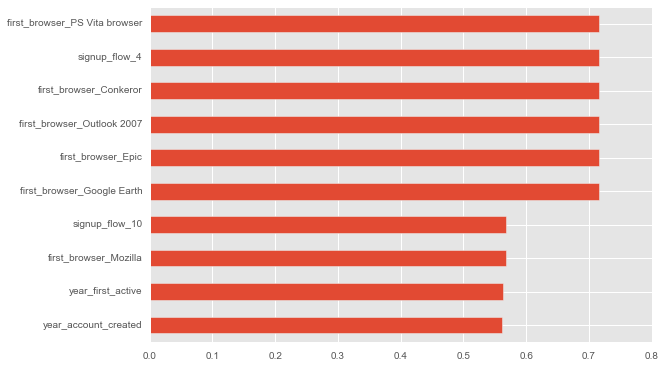

In [94]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)
#FeatureScores = pd.Series(index=X_train_fs.columns,data=X_train_fs.scores_).sort_values(ascending=False)
print X_train.shape
print X_train_fs.shape
FeatureScores = pd.Series(index=features.columns, data=fs.scores_).sort_values(ascending=True)
FeatureScores[:10].plot.barh();

### Impact of Feature Selection

In [95]:
t0 = time()
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
print "done in %0.3fs" % (time() - t0)
measure_performance(X_train_fs, y_train, dt, show_accuracy=True, show_classification_true=True, show_confussion_matric=True)

done in 1.324s
Accuracy:0.819 

Classification report
             precision    recall  f1-score   support

          0       0.68      0.65      0.66       381
          1       0.69      0.63      0.66      1031
          2       0.72      0.66      0.69       746
          3       0.67      0.61      0.64      1556
          4       0.72      0.63      0.67      3562
          5       0.74      0.61      0.67      1628
          6       0.72      0.58      0.64      2029
          7       0.81      0.96      0.88     87102
          8       0.87      0.52      0.65       539
          9       0.92      0.46      0.61       151
         10       0.87      0.66      0.75     43678
         11       0.97      0.44      0.61      7012

avg / total       0.83      0.82      0.81    149415


Confussion matrix
[[  248     0     0     0     0     0     0    97     0     0    34     2]
 [    1   646     0     0     1     0     1   301     0     0    79     2]
 [    2     5   492     0     0 

In [96]:
t0 = time()
y_pred_fs = dt.predict(X_test_fs)
print "done in %0.3fs" % (time() - t0)
print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred_fs)), "\n"
print metrics.classification_report(y_test, y_pred_fs)
print metrics.confusion_matrix(y_test, y_pred_fs)

done in 0.038s
Accuracy:0.536 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       158
          1       0.00      0.01      0.00       397
          2       0.00      0.00      0.00       315
          3       0.02      0.02      0.02       693
          4       0.02      0.03      0.03      1461
          5       0.02      0.02      0.02       696
          6       0.02      0.02      0.02       806
          7       0.65      0.76      0.70     37441
          8       0.01      0.00      0.01       223
          9       0.00      0.00      0.00        66
         10       0.41      0.30      0.35     18698
         11       0.07      0.04      0.05      3082

avg / total       0.51      0.54      0.52     64036

[[    0     4     2     2    10     3     3    80     3     0    49     2]
 [    3     2     3     6    14     4     4   246     2     0    95    18]
 [    1     5     1    11    14     5     3   182     1     0    85     7

# Random Forest

Characteristics:
* low bias
* high variance
* prone to overfitting

Tuning Parameters:
* number of trees
* number of features to consider at each split
* depth of trees

### Gridsearch

# Source Additional Data
Some additional data that has been made available, but which I chose not to include in the analysis were User Sessions data. This dataset might hold important metrics to improve the performance of destination predictions, but the session data only has a small overlap with users in the training dataset that atarted with Airbnb in the first 6 months of 2014.

The supplied Demographics and Countries data files did not seem to hols any value other than providing context.

# Recommendations
A final paper explaining the problem, your approach and your findings in complete technical detail. Include ideas for further research, as well as up to 3 concrete recommendations for your client on how to use your findings.

# Further Research

Other avenues worth exploring include the use of additional techniques to work with imbalanced classes, such as generating synthetic samples (e.g. Synthetic Minority Over-Sampling Techniques, SMOTE). 

From what I've [read](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/), decision tree algorithms like C4.5, C5.0, CART, and Random Forest often perform well on imbalanced data sets.

In addition, penalised models using something like a CostSensitiveClassifier might help. As well as brining in additional peformance metrics like Cohen's kappa which is said to normalise the imbalance within the dataset. 

In [ ]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
# you need to run the line above only once
%load_ext version_information
#%reload_ext version_information

%version_information numpy, scipy, matplotlib

# Acknowledgements
I have learnt a lot from the work of the following influencers:
* David Gasquez's https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/user-data-exploration/notebook
* Kevin Wu's https://www.kaggle.com/kevinwu06/airbnb-recruiting-new-user-bookings/airbnb-exploratory-analysis/notebook
* Aissa EL OUAFI's https://github.com/aissaelouafi/Airbnb-First-Booking/blob/master/Airbnb_first_booking_destination.ipynb
* Analytics Vidhya blog: http://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/
* http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
* https://www.packtpub.com/big-data-and-business-intelligence/learning-scikit-learn-machine-learning-python